In [1]:
from transitions import *
from transitions.mixins import MachineGraphSupport as MGraph
from IPython.display import Image, display, display_png

class Matter(object):
    pass

# Mixin the graph
class MyGraphMachine(MGraph, Machine):
    def __init__(self, *args, **kwargs):
        super(MyGraphMachine, self).__init__(*args, **kwargs)

    def show_graph(self):
        self.graph.draw('state.png', prog='dot')
        display(Image('state.png'))        

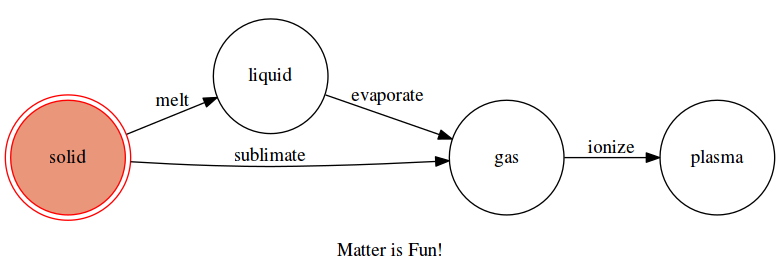

In [2]:
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma' }
]
states=['solid', 'liquid', 'gas', 'plasma']

machine = MyGraphMachine(model=Matter(), 
                         states=states, 
                         transitions=transitions, 
                         auto_transitions=False, 
                         initial='solid', 
                         title="Matter is Fun!")
machine.show_graph()

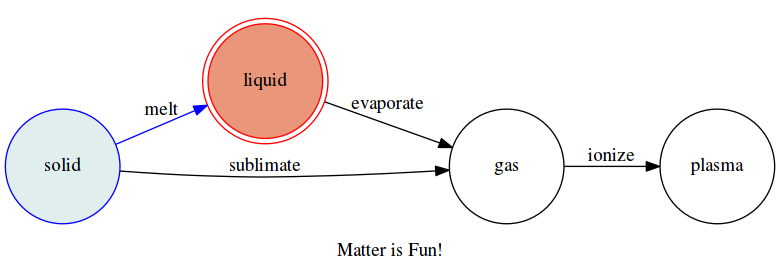

In [3]:
machine.model.melt()
machine.show_graph()

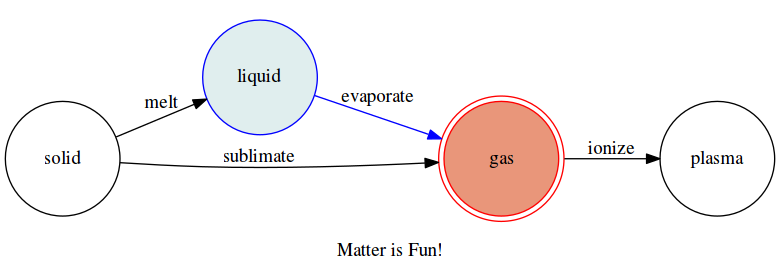

In [4]:
machine.model.evaporate()
machine.show_graph()

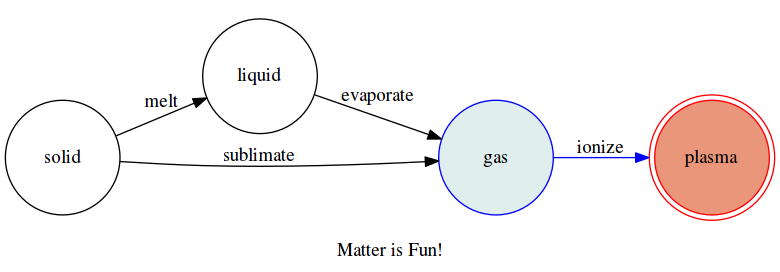

In [5]:
machine.model.ionize()
machine.show_graph()